# Dense Neural Networks

Hello there!

In the previous approach we have considered a linear estimation for the bio-activity. Our result presents an average $R^{2}=0.62$ and a MAPE of $7.19$ In this notebook, we present a new approach by the use of Deep Neural Networks, in this initial case we use only Dense Layers or a Feed Forward. The descriptors used are obtained by the use of Mutual Information (MI). We've first selected those descriptors with a higher mutual than $0.4$, where we've reduced the dimension from 1200 to just 99 descriptors.

Then, we have selected from the 99 descriptors the one descriptor with the highest MI (piPC4) and have selected two variables that are independent among them. This means, the MI values among them is the lowest value possible.

## Used libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
colab = False

In [3]:
if colab: 
    import sys
    sys.path.append('/content/drive/MyDrive/Colaboracion_Quimica/Main_Codes/AutoEncoders/AmaroX/AmaroX')
    ! pip install python-telegram-bot

    from ai_functions import *
    from ai_models import *
    from utilities import *
    from data_manipulation import *
    import pandas as pd
else: 
    from AmaroX.AmaroX.ai_functions import *
    from AmaroX.AmaroX.ai_models import *
    from AmaroX.AmaroX.utilities import *
    from AmaroX.AmaroX.data_manipulation import *
    import pandas as pd

2025-08-12 15:06:39.218829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-12 15:06:40.716546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alan-amaro/miniconda3/envs/farma/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
import keras_tuner
import sklearn

## Data

The data presented here corresponds to molecules with their SMILE representation and descriptors, along with the biological activity. Let's first do a quick view of the data shape.

* All the data presented here was obtained by colaboration with Dr. Erick Padilla at Facultad de Estudios Superiores Zaragoza - UNAM.

### Downloading the data

In [5]:
if colab:
    ! gdown --id 1cHM9neEhTOZ82UU9HaZkdGdlwE1d4SJT
    ! gdown --id 1wZp9pou63ElEYyGGjBeC2pDtscgRgCpj

The _data.xlsx_ file contains all the molecular descriptors from the molecule, along with a SMILE representation.

In [6]:
compounds_md = pd.read_excel("../Data/data.xlsx")
activity = pd.read_excel("../Data/Actividad.xlsx")

In [7]:
compounds_md.head()

,Cmpd,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,Compuesto original,O=C(N/1)/C(SC1=N/C2=NC3=CC=C(F)C=C3S2)=C/N4CCN...,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,3,34.64084,2.428932,4.709973,34.64084,...,10.158170,78.17227,405.1093,8.619347,2138,39,146,171,8.361111,5.750000
1,Compound 3,O=C1NC2=CC=C([H])C=C2/C1=N\C3=CC=CC(Br)=N3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,23.43385,2.452376,4.754134,23.43385,...,9.792612,65.48686,300.9851,11.576350,599,26,96,113,5.166667,3.916667
2,Compound 4,O=C1NC2=CC=CC=C2/C1=N\C3=NC4=CC(OCC)=CC=C4S3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,30.43085,2.474251,4.745881,30.43085,...,10.101640,73.78306,323.0728,8.974246,1245,35,126,151,6.138889,5.027778
3,Compound 8,O=C1NC2=CC=C(Br)C=C2/C1=N\C3=CC=CC(F)=N3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,24.52891,2.46582,4.787297,24.52891,...,9.873183,66.82214,318.9757,12.268290,693,28,102,120,6.027778,4.083333
4,Compound 9,O=C1NC2=CC=C(Br)C=C2/C1=N/C3=CC([N+]([O-])=O)=...,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,27.00118,2.467278,4.80069,27.00118,...,9.972407,69.29945,345.9702,12.356080,929,32,112,132,7.138889,4.527778


In [8]:
compounds_md.shape

(71, 1828)

In [9]:
activity.head()

,Activity
0,5.005513
1,4.381642
2,4.114064
3,5.012402
4,5.047677


In [10]:
activity.shape

(71, 1)

* The variable _x_ are the molecular descriptors, we're only interested in numerical properties:

In [11]:
x = compounds_md.copy()
x = x.select_dtypes("number")

## Applying Mutual Information to Molecular Descriptors

In the previous notebook, we have selected 3 molecular descriptors that are independent among them and present a high MI with respect to the bio-activity.

In [12]:
x_array = np.array(x[ ['piPC4', 'GATS3i', 'SssNH'] ])
x_array.shape

(71, 3)

In [13]:
y_array = np.array( activity )[:, 0]
y_array.shape

(71,)

## Standarize Features

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [15]:
x_std = scaler.fit_transform(x_array)
x_std.shape

(71, 3)

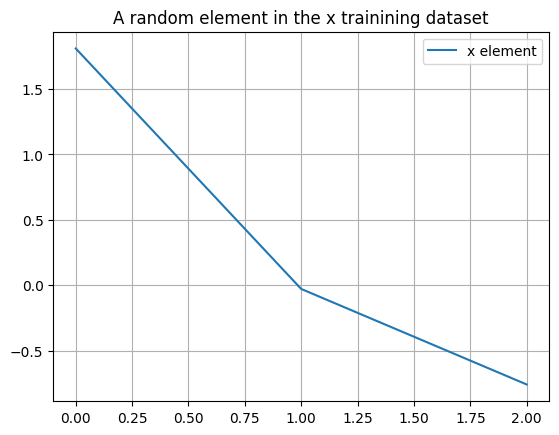

The corresponding y element -> 4.92056641


In [16]:
plot_xy([x_std, y_array])

## Splitting Train and Test

In [17]:
N_BINS=6 ##discretizer, this was 10 before
N_SPLITS=6 ##splitter
TEST_SIZE=21/70 ##splitter

In [18]:
# dividimos train test con stratified
discretizer = sklearn.preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="uniform")
splitter = sklearn.model_selection.StratifiedShuffleSplit(n_splits=N_SPLITS,test_size=TEST_SIZE, random_state=13)
y_discrete = discretizer.fit_transform(np.expand_dims(y_array, axis = -1))
split, split_test = next(splitter.split(np.expand_dims(x_std, axis = -1), y_discrete ))

In [19]:
x_train = x_std[split]
x_test = x_std[split_test]
y_train = y_array[split]
y_test = y_array[split_test]

In [20]:
x_train.shape, x_test.shape

((49, 3), (22, 3))

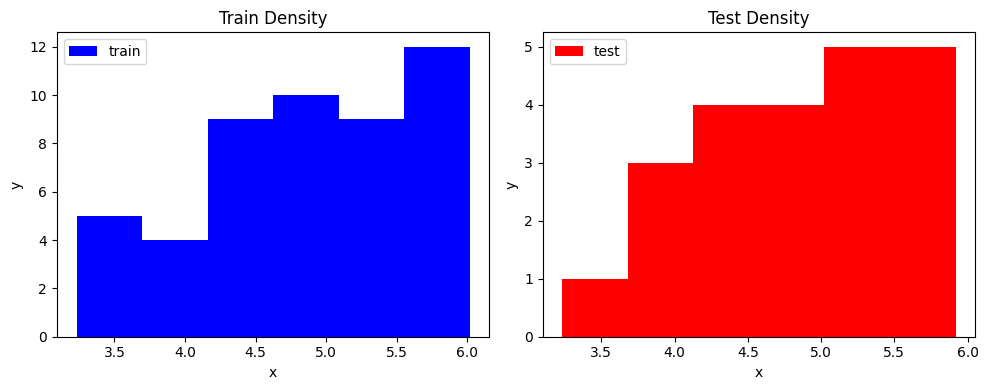

In [21]:
# Crear una figura con dos subplots en horizontal (1 fila, 2 columnas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # figsize ajusta el tamaño

# Graficar la primera curva en el primer subplot
ax1.hist(y_train, color='blue', label='train', bins = 6)
ax1.set_title('Train Density')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()

# Graficar la segunda curva en el segundo subplot
ax2.hist(y_test, color='red', label='test', bins = 6)
ax2.set_title('Test Density')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend()

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

## Paths

In [22]:
name = 'DNN_MI_3'
if colab:
    folder_path = '/content/drive/MyDrive/Colaboracion_Quimica/Main_Codes/AutoEncoders/models'
else: 
    folder_path = '../models'
    
final_path = os.path.join(folder_path, name)

## Callbacks

In [23]:
callbacks = standard_callbacks(folder_name= name,
                               folder_path= folder_path,
                               patiences= [150, 150], # 50 epochs without progress, and 2 epochs to reduce LR
                               monitor = 'val_r2_score',
                               flow_direction = 'max')

## DNN Model

In [24]:
def _DNN(nodes:list):

  inputs = keras.layers.Input((3,))

  _DNN_ = G_Dense(
      inputs = inputs,
      nodes = nodes,
      DP = 5,
      n_final = 1,
      act_func = 'leaky_relu',
      final_act_func = 'relu',
      WI = 'he_normal',
      L1 = 0.0,
      L2 = 0.0,
      use_bias = True
  )

  return keras.models.Model(inputs = inputs, outputs = _DNN_)

In [25]:
def compile_model(nodes: list, optimizer, modelo):

  model = modelo(nodes = nodes)

  model.compile(optimizer = optimizer,
                loss = 'mae',
                metrics = ['mape', 'r2_score'])

  return model

In [26]:
def build_model(hp):

  nodes = [hp.Int('Nodes-1', min_value = 1, max_value = 300, step = 1),
           ]

  #DP = hp.Int('Dropout', min_value = 0, max_value = 50, step = 2)

  #L1 = hp.Choice('L1', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])

  #L2 = hp.Choice('L2', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])

  optimizer = hp.Choice('optimizer', ['adam'])

  if optimizer == 'adam': opt = keras.optimizers.Adam(
        learning_rate = 0.001
    )

  elif optimizer == 'sgd': opt = keras.optimizers.SGD(
        learning_rate = 0.001
    )

  elif optimizer == 'adagrad': opt = keras.optimizers.Adagrad(
        learning_rate = 0.001
    )


  model_f = compile_model(nodes = nodes, optimizer = optimizer, modelo = _DNN)

  return model_f

In [27]:
build_model(keras_tuner.HyperParameters())

2025-08-12 15:07:22.903296: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-12 15:07:22.903364: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: alan-amaro-Nvidia
2025-08-12 15:07:22.903386: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: alan-amaro-Nvidia
2025-08-12 15:07:22.903721: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 570.169.0
2025-08-12 15:07:22.903780: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 570.169.0
2025-08-12 15:07:22.903799: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 570.169.0


<Functional name=functional, built=True>

In [28]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective= keras_tuner.Objective('val_mape', 'min') ,
    max_trials= 50, # Set to 3
    executions_per_trial = 2,
    overwrite=True,
    directory= final_path,
    project_name="DNN1-MI-KT",
)

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
Nodes-1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 300, 'step': 1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam'], 'ordered': False}


In [30]:
tuner.search(x_train, y_train, epochs=250, validation_data=(x_test, y_test), batch_size=12)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
51                |51                |Nodes-1
adam              |adam              |optimizer

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 4.3231 - mape: 89.9269 - r2_score: -36.6511 - val_loss: 4.3529 - val_mape: 89.5351 - val_r2_score: -37.6739
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.1919 - mape: 87.3338 - r2_score: -29.3092 - val_loss: 4.2311 - val_mape: 86.9160 - val_r2_score: -36.1923
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.1346 - mape: 84.9055 - r2_score: -30.2132 - val_loss: 4.1250 - val_mape: 84.6354 - val_r2_score: -35.0430
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.1615 - mape: 85.1187 - r2_score: -29.6171 - val_loss: 4.0258 - val_mape: 82.5126 - val_r2_score: -34.0210
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.9582 - mape: 81.3300 - r2_score: -30.2232 - val_loss: 3.9288 - val_mape: 80.4434 - val_r2_score: -33

KeyboardInterrupt: 

In [ ]:
file_path = os.path.join(final_path, 'best_models.txt')

with open(file_path, "w") as file:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        sys.stdout = file  # Redirect stdout to the file
        tuner.results_summary()  # Call your function
    finally:
        sys.stdout = original_stdout